In [1]:
from util.sparkhandler import SparkHandler
from util.dataproctools import get_extracted_wet, save_rdd, load_rdd
from util.dataproctools import extracted_wet_to_df
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import optuna

In [2]:
handler = SparkHandler(available_cores=4) # look at the parameters for SparkHandler to increase max memory
ss = handler.get_spark_session()
sc = handler.get_spark_context()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 19:10:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/10 19:10:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/12/10 19:10:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/12/10 19:10:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
raw_data = get_extracted_wet(spark_context=sc, approx_sample_size=20000, wet_paths_file="data/wet.paths")
save_rdd(raw_data, "saved_intermediates/rawStrRDD", overwrite=True)

In [4]:
# raw_data = load_rdd(spark_context=sc, path_to_load="../saved_intermediates/rawStrRDD")

In [17]:
df = extracted_wet_to_df(spark_session=ss, extracted_wet_rdd=raw_data)
filtered = df.filter(((df.tld == '.gov') | (df.tld == '.edu')) & (df.languages == 'eng'))
filtered.write.mode("overwrite").format("json").save("saved_intermediates/filtered_dataframe")

In [3]:
loaded_df = ss.read.json("saved_intermediates/filtered_dataframe")

In [4]:
loaded_df.head()

Row(date='2025-11-15T20:46:04Z', languages='eng', raw_content='\r\nVirginia Tech Dendrology Fact Sheet\nVirginia Tech Dendrology\nCalifornia red fir Pinaceae Abies magnifica A. Murray bis symbol: ABMA\nLeaf: Flattened needles, about 1 inch long, linear, and 4-angled in cross-section with a ridge on top along the midrib; bluish white bloom on all surfaces; base curves, making the needle resemble a hockey stick; tips mostly rounded but may be pointed on cone-bearing branches; spirally arranged but usually upswept.\nFlower: Species is monoecious; male cones purple to dark red and borne on undersides of branches; female cones are reddish-brown and borne upright near the top of the crown.\nFruit: Cones are 6 to 9 inches long, cylindrical, and borne upright on the twig; cone scales are deciduous, falling from the cone as seeds ripen; purple when mature; bracts are shorter than the scales (as opposed to noble fir). Shasta red fir (a hybrid) has bracts longer than cone scales.\nTwig: Stiff, re

In [5]:
tuning_sample = loaded_df.sample(0.2)
train, val, test = tuning_sample.randomSplit([0.7, 0.2, 0.1], seed=1237)

In [37]:
def objective(trial: optuna.trial.Trial):

    minTokenLength = trial.suggest_int("min word len", 1, 3)
    k = 12
    learningDecay = trial.suggest_float("lr decay", 0.5, 1.0)
    learningOffset = trial.suggest_float("offset", 0, 10)
    maxItr = trial.suggest_int("intrs", 10, 100)
    subsamplingRate = trial.suggest_float("subsampling rate", 0, 1)

    # 1) Tokenize text into tokens
    tokenizer = RegexTokenizer(minTokenLength=minTokenLength, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

    # 2) Remove stopwords
    remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

    # 3) Convert tokens to term-frequency vectors
    cv = CountVectorizer(
        inputCol="filtered",
        outputCol="features",
        vocabSize=5000,
        minDF=1    # keep terms that appear in at least 1 document
    )

    # 4) LDA model (k = number of topics)
    lda = LDA(
        k=k,
        learningDecay=learningDecay,
        learningOffset=learningOffset,
        maxIter=maxItr,
        subsamplingRate=subsamplingRate,
        featuresCol="features"
    )

    # 5) Build pipeline
    pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])
    model = pipeline.fit(train)
    valed = model.transform(val)
    perplexity = model.stages[-1].logPerplexity(valed)
    log_likelyhood = model.stages[-1].logLikelihood(valed)
    return perplexity, log_likelyhood

In [38]:
study = optuna.create_study(directions=["minimize", "maximize"])

[I 2025-12-10 19:27:41,700] A new study created in memory with name: no-name-14851bef-200b-45ab-9354-9d1874881182


In [39]:
study.optimize(objective, n_trials=10, timeout=300, n_jobs=8)

[I 2025-12-10 19:27:45,187] Trial 0 finished with values: [12.125409692436545, -77736.0015382107] and parameters: {'min word len': 2, 'lr decay': 0.823962124981559, 'offset': 2.217983092932725, 'intrs': 11, 'subsampling rate': 0.8981623913855593}.
[I 2025-12-10 19:27:45,575] Trial 1 finished with values: [12.274977605264603, -73527.11585553497] and parameters: {'min word len': 3, 'lr decay': 0.9514671064820741, 'offset': 2.0168438307330785, 'intrs': 20, 'subsampling rate': 0.10845387709312371}.
[I 2025-12-10 19:27:45,661] Trial 4 finished with values: [11.473512422484834, -80681.73935491336] and parameters: {'min word len': 1, 'lr decay': 0.5427331744791298, 'offset': 0.1541422324550623, 'intrs': 22, 'subsampling rate': 0.11541072088761795}.
[I 2025-12-10 19:27:46,871] Trial 3 finished with values: [10.570323771805588, -67766.34570104563] and parameters: {'min word len': 2, 'lr decay': 0.6161629616929358, 'offset': 3.5059614585486454, 'intrs': 36, 'subsampling rate': 0.2472138728299744

In [40]:
best_params = study.best_trials[-1].params
best_params

{'min word len': 3,
 'lr decay': 0.6538647947474596,
 'offset': 8.84701924686076,
 'intrs': 94,
 'subsampling rate': 0.7387623023070996}

In [41]:
#def objective(trial: optuna.trial.Trial):

minTokenLength = best_params['min word len']
k = 12
learningDecay = best_params['lr decay']
learningOffset = best_params['offset']
maxItr = best_params['intrs']
subsamplingRate = best_params['subsampling rate']

# 1) Tokenize text into tokens
tokenizer = RegexTokenizer(minTokenLength=minTokenLength, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

# 2) Remove stopwords
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

# 3) Convert tokens to term-frequency vectors
cv = CountVectorizer(
    inputCol="filtered",
    outputCol="features",
    vocabSize=5000,
    minDF=1    # keep terms that appear in at least 1 document
)

# 4) LDA model (k = number of topics)
lda = LDA(
    k=k,
    learningDecay=learningDecay,
    learningOffset=learningOffset,
    maxIter=maxItr,
    subsamplingRate=subsamplingRate,
    featuresCol="features"
)

# 5) Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])
model = pipeline.fit(loaded_df)
transformed = model.transform(loaded_df)

In [42]:
#here we are just importing neccesary packages.
import matplotlib.pyplot as plt
import pandas as pd


# We allow for the use of either Wordcloud or Seaborn for visualization
try:
    from wordcloud import WordCloud
    HAS_WORDCLOUD = True
except ImportError:
    HAS_WORDCLOUD = False

try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False


from pyspark.ml.linalg import DenseVector, SparseVector


#here we create a function to create visualzations based on the results we get from LDA
def visualize_topics(lda_model, vocabulary, df_transformed=None, num_words=10):

    topics_df = lda_model.describeTopics(maxTermsPerTopic=num_words)
    topics = topics_df.collect()


    topic_labels = {}
    for row in topics:
        top_terms = [vocabulary[i] for i in row.termIndices[:3]]  # this is giving the top 3 words
        label = f"Topic {row.topic} — ({', '.join(top_terms)})"
        topic_labels[row.topic] = label



    # Here we are creating our first visualzation: Bar Charts.
    num_topics = len(topics)
    fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 6))
    if num_topics == 1:
        axes = [axes]

    for idx, topic_row in enumerate(topics):
        term_indices = topic_row.termIndices
        term_weights = topic_row.termWeights
        words = [vocabulary[i] for i in term_indices]
        weights = [float(w) for w in term_weights]

        ax = axes[idx]
        ax.barh(words, weights)
        ax.set_title(topic_labels[topic_row.topic])
        ax.set_xlabel("Weight")
        ax.invert_yaxis() # we do this so that the highest weight is at the top.

    plt.tight_layout()
    plt.show()

    # Here we are creating our second  visualzation:Word Clouds.
    if HAS_WORDCLOUD:
        fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 4))
        if num_topics == 1:
            axes = [axes]

        for idx, topic_row in enumerate(topics):
            term_indices = topic_row.termIndices
            term_weights = topic_row.termWeights
            word_freq = {vocabulary[i]: float(w) for i, w in zip(term_indices, term_weights)}

            wordcloud = WordCloud(width=425, height=325, background_color="white") \
                .generate_from_frequencies(word_freq)

            axes[idx].imshow(wordcloud, interpolation="bilinear")
            axes[idx].set_title(topic_labels[topic_row.topic])
            axes[idx].axis("off")

        plt.tight_layout()
        plt.show()

    # Here we are creating our third visualzation: Document Topic Distributions.
    if df_transformed is not None:

     # we want to extract the topic distribution column from the df which is containing the vector of probabilites
        rows = df_transformed.select("topicDistribution").collect()
        topic_probs = []
        for row in rows:
            dist = row.topicDistribution

            if isinstance(dist, (DenseVector, SparseVector)):
                dist = dist.toArray()
            topic_probs.append([float(x) for x in dist])

        df_topics = pd.DataFrame(
            topic_probs,
            columns=[topic_labels[i] for i in range(num_topics)]
        )

        fig, ax = plt.subplots(figsize=(8, 5))
        topic_means = df_topics.mean()
        ax.bar(topic_means.index, topic_means.values)
        ax.set_ylabel("Average Probability")
        ax.set_title("Average Topic Proportions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        if HAS_SEABORN:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.heatmap(df_topics.T, cmap="YlOrRd", cbar_kws={"label": "Probability"}, ax=ax)
            ax.set_xlabel("Document")
            ax.set_ylabel("Topic")
            ax.set_title("Document-Topic Distribution")
            plt.tight_layout()
            plt.show()



# Here we are calling the visualizations. Uncomment when you want to employ it.
# visualize_topics(lda_model, vocab, transformed, num_words=10)


In [43]:
# Extract the CV and LDA sub-models
cv_model = model.stages[2]
lda_model = model.stages[3]

vocab = cv_model.vocabulary

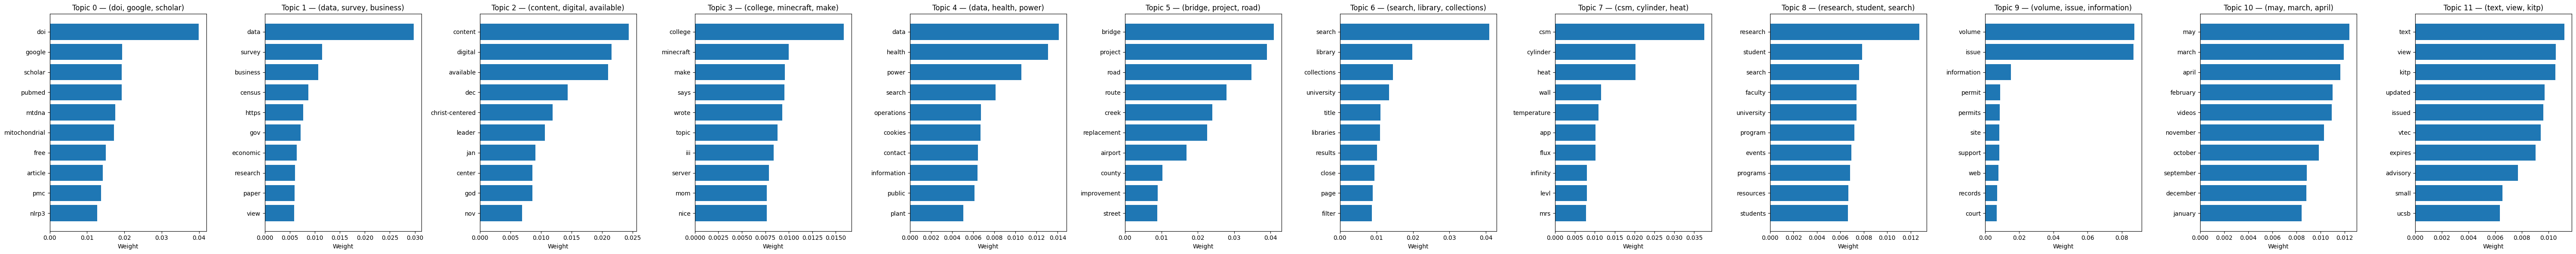

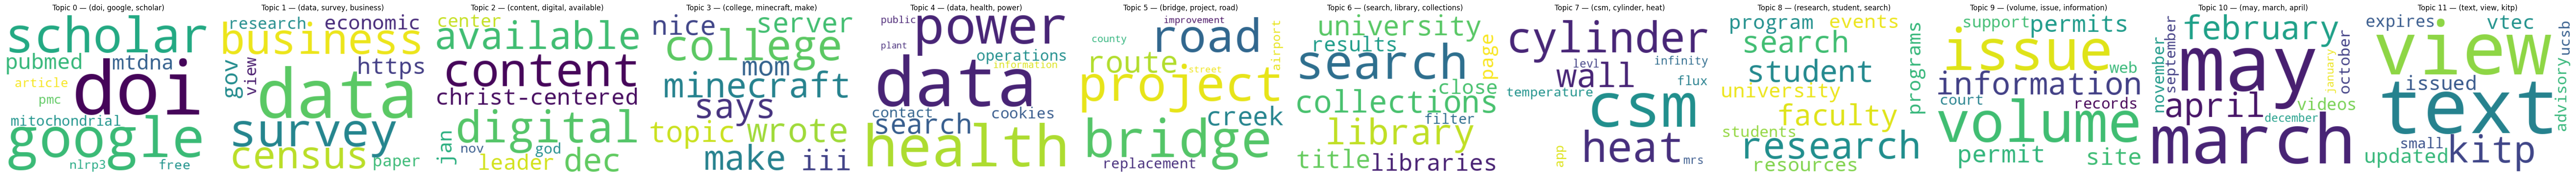

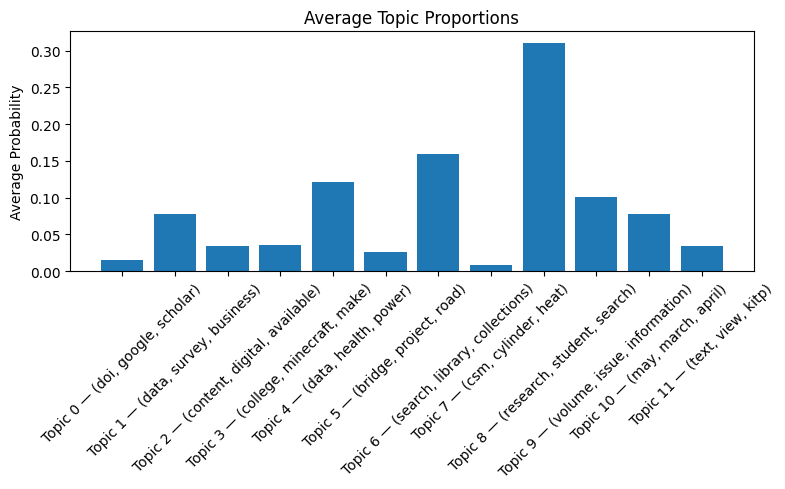

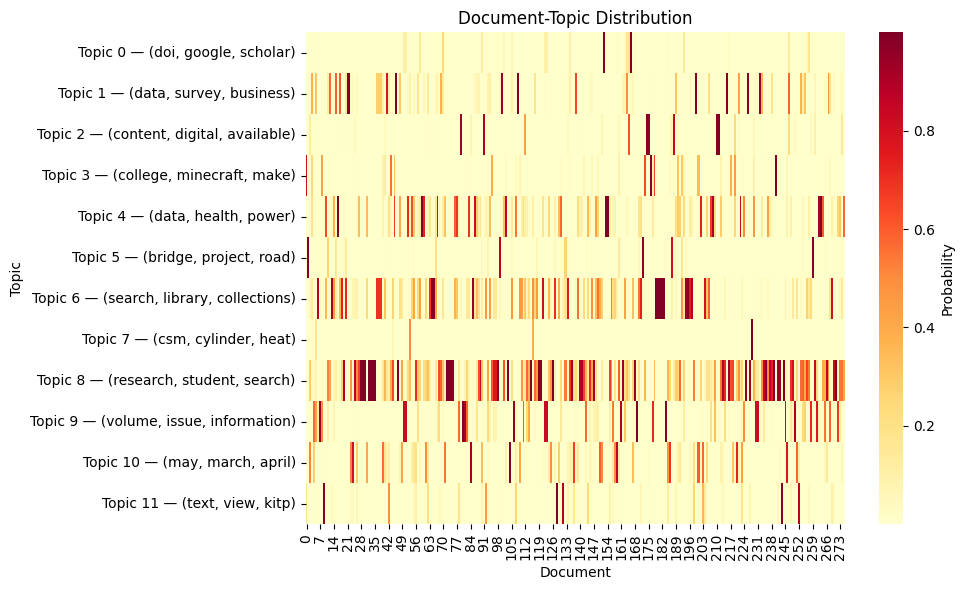

In [44]:
visualize_topics(lda_model, vocab, transformed, num_words=10)